<div style="background-color:#e8f5e9; padding:20px; border-radius:10px; text-align:center;">

# XGBoost - Backtesting  
**by A.B.**

<br>

This notebook explores the use of the XGBoost algorithm + Nueral Network Classifier for financial market prediction.  
By leveraging historical price and engineered features (like EMA, ATR, and volatility thresholds),  
we train and evaluate an XGBoost classifier + Nueral Network to detect potential trading signals.  
The model is then backtested to assess predictive performance and robustness in realistic conditions.

</div>

<br>

Slice first 10k rows to save time to conduct experiments.

In [1]:
import pandas as pd
df = pd.read_csv("EURUSD_Candlestick_5_M_ASK_30.09.2021-30.09.2024.csv")
df = df.loc[:50000]

around 6 months data 

### Long Positions Volatility Related Labeling
Detecting potential long trades.Calculating dynamic upper and lower thresholds around the current price. 
* price exceeding upper threshold -> uptrend
* price exceeding lower threshold -> downtrend

In [2]:
import pandas_ta as ta
def atr_label_threshold_long(df, bars):
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'])

    ratio = 1
    slcoef = 1
    tpcoef = ratio*slcoef

    lower_threshold_long = df['Close'] - df['ATR']*slcoef
    upper_threshold_long = df['Close'] + df['ATR']*tpcoef

    df = df.reset_index(drop=True)

    df['Label_Long'] = 0
    for i in range(len(df) - bars):   
       
        # Check if any future Close prices are above the upper threshold at the current index
        condition_1 = (df['Close'][i + 1:i + bars + 1] > upper_threshold_long.iloc[i]).any()
        # Ensure none of the future Close prices are below the lower threshold at the current index
        condition_2 = (df['Close'][i + 1:i + bars + 1] > lower_threshold_long.iloc[i]).all()

        # Set label based on conditions
        if condition_1 and condition_2:
            df.loc[i, 'Label_Long'] = 1

    return df

In [3]:
df = atr_label_threshold_long(df, 10)

This small offset ensures signal markers don’t overlap the candlestick visuals when plotting.

In [4]:
import numpy as np
def pointpos(x, col):
    if x[col]==1:
        return x['Low']-1e-3
    elif x[col]==-1:
        return x['High']+1e-3
    else:
        return np.nan

### Short Positions Volatility Related Labeling

Detecting potential short trades.  
- The future closing price drops  below a lower threshold    at least once and
- The price  never exceeds an upper threshold  during the lookahead period.

In [5]:
def atr_label_threshold_short(df, bars):
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'])

    ratio = 1
    slcoef = 1
    tpcoef = ratio*slcoef

    lower_threshold_short = df['Close'] - df['ATR']*tpcoef
    upper_threshold_short = df['Close'] + df['ATR']*slcoef

    df = df.reset_index(drop=True)

    # conditions for a short position where we're 
    # looking for the price to drop below a lower 
    # threshold without crossing an upper threshold in the future.

    df['Label_Short'] = 0
    for i in range(len(df) - bars):
        
        # Check if any future Close prices are below the lower threshold at the current index
        condition_1 = (df['Close'][i + 1:i + bars + 1] < lower_threshold_short.iloc[i]).any()
        
        # Ensure none of the future Close prices are above the upper threshold at the current index
        condition_2 = (df['Close'][i + 1:i + bars + 1] < upper_threshold_short.iloc[i]).all()
        
        # Set label based on conditions
        if condition_1 and condition_2:
            df.loc[i, 'Label_Short'] = -1

    return df

In [6]:
df = atr_label_threshold_short(df, 10)

In [7]:
df["Label"] = df["Label_Long"] + df["Label_Short"]
df[df["Label"]!=0]

,Gmt time,Open,High,Low,Close,Volume,ATR,Label_Long,Label_Short,Label
16,30.09.2021 01:20:00.000,1.16044,1.16044,1.16015,1.16032,134.420000,0.000179,1,0,1
17,30.09.2021 01:25:00.000,1.16031,1.16035,1.16021,1.16027,109.230000,0.000175,1,0,1
18,30.09.2021 01:30:00.000,1.16028,1.16034,1.16014,1.16031,141.430000,0.000178,1,0,1
19,30.09.2021 01:35:00.000,1.16030,1.16053,1.16026,1.16052,202.500000,0.000186,1,0,1
20,30.09.2021 01:40:00.000,1.16053,1.16061,1.16040,1.16045,123.360000,0.000189,1,0,1
...,...,...,...,...,...,...,...,...,...,...
49985,27.05.2022 20:30:00.000,1.07308,1.07320,1.07306,1.07311,0.000117,0.000358,1,0,1
49986,27.05.2022 20:35:00.000,1.07312,1.07312,1.07307,1.07309,0.000107,0.000336,1,0,1
49987,27.05.2022 20:40:00.000,1.07306,1.07315,1.07304,1.07309,0.000121,0.000320,1,0,1
49988,27.05.2022 20:45:00.000,1.07309,1.07340,1.07308,1.07314,0.000273,0.000320,1,0,1


In [8]:
df['pointpos'] = df.apply(lambda row: pointpos(row,"Label"), axis=1)

Qickly assess the quality and positioning of labeled signals in the context of price action.

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+350]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")

fig.show()

### Adding EMA and EMA Slope as features

In [10]:
df["ema30"] = ta.ema(df['Close'], length=30)
df

,Gmt time,Open,High,Low,Close,Volume,ATR,Label_Long,Label_Short,Label,pointpos,ema30
0,30.09.2021 00:00:00.000,1.16018,1.16019,1.15980,1.15997,319.83,NaN,0,0,0,NaN,NaN
1,30.09.2021 00:05:00.000,1.15996,1.16002,1.15982,1.15992,124.99,NaN,0,0,0,NaN,NaN
2,30.09.2021 00:10:00.000,1.15991,1.16006,1.15979,1.16002,155.57,NaN,0,0,0,NaN,NaN
3,30.09.2021 00:15:00.000,1.16002,1.16013,1.15998,1.16012,214.94,NaN,0,0,0,NaN,NaN
4,30.09.2021 00:20:00.000,1.16011,1.16021,1.16011,1.16021,123.87,NaN,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
49996,28.05.2022 00:25:00.000,1.07393,1.07393,1.07393,1.07393,0.00,0.000223,0,0,0,NaN,1.073135
49997,28.05.2022 00:30:00.000,1.07393,1.07393,1.07393,1.07393,0.00,0.000207,0,0,0,NaN,1.073186
49998,28.05.2022 00:35:00.000,1.07393,1.07393,1.07393,1.07393,0.00,0.000192,0,0,0,NaN,1.073234
49999,28.05.2022 00:40:00.000,1.07393,1.07393,1.07393,1.07393,0.00,0.000179,0,0,0,NaN,1.073279


In [11]:
from scipy.stats import linregress

def compute_slope(window):
    # Use only the last 5 values of the window
    if len(window) < 5:
        return np.nan  # Not enough data to compute the slope
    y = window[-5:]
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

# Apply the function to compute the slope of ema20
df['ema30_Slope'] = df['ema30'].rolling(window=5, min_periods=5).apply(compute_slope, raw=True)

### Adding more Moving Averages

 - Returns 1 if the shorter-term EMA is above both longer-term EMAs -bullish
  - Returns  -1  if the shorter-term EMA is below both - bearish 
  - Returns 0  otherwise  uncertain or transitioning trend .

In [12]:
df['ema50'] = ta.ema(df['Close'], length=50)
df['ema100'] = ta.ema(df['Close'], length=100)

In [13]:
def ema_positions(row):
    if row['ema30'] > row['ema50'] > row['ema100']:
        return 1
    elif row['ema30'] < row['ema50'] < row['ema100']:
        return -1
    else:
        return 0

In [14]:
# Apply the function to create the 'ema_Positions' column for later use
df['ema_Positions'] = df.apply(ema_positions, axis=1)

### Moving Average Distance

 can be used to detect pullback opportunities or overextensions

In [15]:
def compute_distance(row):
    # Determine the closest point to EMA20 (either Open or Close)
    closest_point = min(row['Open'], row['Close'], key=lambda x: abs(x - row['ema30']))
    # Compute the absolute distance between the closest point and EMA20
    distance = row['ema30'] - closest_point
    return distance

In [16]:
df['Distance_to_ema30'] = df.apply(compute_distance, axis=1)

### Putting all indicators in place

In [17]:
df['RSI']=ta.rsi(df.Close, length=10)
my_bbands = ta.bbands(df.Close, length=15, std=1.5)
df=df.join(my_bbands)

In [18]:

def ema_signal(df, current_candle, backcandles):
    df_slice = df.reset_index().copy()
    # Get the range of candles to consider
    start = max(0, current_candle - backcandles)
    end = current_candle
    relevant_rows = df_slice.iloc[start:end]

    # Check if all EMA_fast values are below EMA_slow values
    if all(relevant_rows["ema30"] < relevant_rows["ema50"]):
        return 1 #downtrend
    elif all(relevant_rows["ema30"] > relevant_rows["ema50"]):
        return 2 #uptrend
    else:
        return 0

def BB_signal(df, current_candle, backcandles):
    candle_open_price = df.Open[current_candle]
    bbl = df['BBL_15_1.5'][current_candle]
    bbu = df['BBU_15_1.5'][current_candle]

    if (candle_open_price<=bbl): #and df.RSI[current_candle]>45
            return 2
    if (candle_open_price>=bbu): #and df.RSI[current_candle]<65
            return 1
    return 0

def total_signal(df, current_candle, backcandles):
    ema_signal_result = ema_signal(df, current_candle, backcandles)
    candle_open_price = df.Open[current_candle]
    bbl = df['BBL_15_1.5'][current_candle]
    bbu = df['BBU_15_1.5'][current_candle]
    #uptred and price below bb
    if (ema_signal_result==2 and candle_open_price<=bbl): #and df.RSI[current_candle]<60
            return 2
    #downtred and price above bb
    if (ema_signal_result==1 and candle_open_price>=bbu): #and df.RSI[current_candle]>40
            return 1
    return 0

In [19]:
# Apply the EMA signal function and save the result in a new column
df['ema_signal'] = [ema_signal(df, i, backcandles=7) for i in range(len(df))]

# Apply the BB signal function and save the result in a new column
df['BB_signal'] = [BB_signal(df, i, backcandles=7) for i in range(len(df))]

# Apply the total signal function and save the result in a new column
df['total_signal'] = [total_signal(df, i, backcandles=7) for i in range(len(df))]

***Super!***   all features are ready.

In [20]:
analyze_col = ["Volume", "ATR", "ema30_Slope", "Distance_to_ema30", 'ema_Positions', "RSI", "ema_signal", "BB_signal", "total_signal", "Label_Long"]
df=df[analyze_col]
# df.columns
df

,Volume,ATR,ema30_Slope,Distance_to_ema30,ema_Positions,RSI,ema_signal,BB_signal,total_signal,Label_Long
0,319.83,NaN,NaN,NaN,0,NaN,1,0,0,0
1,124.99,NaN,NaN,NaN,0,NaN,0,0,0,0
2,155.57,NaN,NaN,NaN,0,NaN,0,0,0,0
3,214.94,NaN,NaN,NaN,0,NaN,0,0,0,0
4,123.87,NaN,NaN,NaN,0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
49996,0.00,0.000223,0.000061,-0.000795,0,78.745149,2,0,0,0
49997,0.00,0.000207,0.000057,-0.000744,0,78.745149,2,0,0,0
49998,0.00,0.000192,0.000053,-0.000696,1,78.745149,2,0,0,0
49999,0.00,0.000179,0.000050,-0.000651,1,78.745149,2,0,0,0


### Data Preprocessing, No Data Leakage

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns


# Drop NA values
df_analysis = df.copy().dropna()

# Define features and label
X = df_analysis.drop(['Label_Long'], axis=1)
y = df_analysis['Label_Long']

# Split the dataset into training and testing sets sequentially
split_ratio = 0.9
split_point = int(len(df_analysis) * split_ratio)
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

# One-Hot Encoding
columns_to_encode = ["ema_Positions", 'ema_signal', 'BB_signal', 'total_signal']
# Generate one-hot encoded variables for both training and testing datasets directly
X_train_encoded = pd.get_dummies(X_train[columns_to_encode], columns=columns_to_encode, prefix=columns_to_encode)
X_test_encoded = pd.get_dummies(X_test[columns_to_encode], columns=columns_to_encode, prefix=columns_to_encode)

# Align the columns of the encoded DataFrames to ensure they have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='outer', axis=1, fill_value=0)

# Apply Polynomial Features and Standardization to numeric features
# Assuming all other features are numeric and need transformation
# poly = PolynomialFeatures(degree=3)
# X_train_poly = poly.fit_transform(X_train.drop(columns=columns_to_encode))
# X_test_poly = poly.transform(X_test.drop(columns=columns_to_encode))

X_train_poly = X_train.drop(columns=columns_to_encode)
X_test_poly = X_test.drop(columns=columns_to_encode)
feature_names = X_train.drop(columns=columns_to_encode).columns

# Standardization
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Get feature names for polynomial features
#feature_names = poly.get_feature_names_out(X_train.drop(columns=columns_to_encode).columns)

# Convert to DataFrame
X_train_poly_df = pd.DataFrame(X_train_poly_scaled, columns=feature_names, index=X_train.index)
X_test_poly_df = pd.DataFrame(X_test_poly_scaled, columns=feature_names, index=X_test.index)

# Join the polynomial features with the encoded features
X_train_final = X_train_poly_df.join(X_train_encoded)
X_test_final = X_test_poly_df.join(X_test_encoded)

# # Apply PCA
# pca = PCA(n_components=3)
# X_train_pca = pca.fit_transform(X_train_final)
# X_test_pca = pca.transform(X_test_final)

# # # Creating DataFrame for PCA components
# columns_pca = ['PC1', 'PC2', "PC3"]
# X_train_pca_df = pd.DataFrame(data=X_train_pca, columns=columns_pca, index=X_train.index)
# X_test_pca_df = pd.DataFrame(data=X_test_pca, columns=columns_pca, index=X_test.index)

# If PCA is not applied, use the final pre-PCA DataFrames for further processing or modeling
X_train_pca_df = X_train_final
X_test_pca_df = X_test_final


### Final data and signals compiled together

In [22]:
X_train_pca_df

,Volume,ATR,ema30_Slope,Distance_to_ema30,RSI,ema_Positions_-1,ema_Positions_0,ema_Positions_1,ema_signal_0,ema_signal_1,ema_signal_2,BB_signal_0,BB_signal_1,BB_signal_2,total_signal_0,total_signal_1,total_signal_2
33,-0.392115,-0.605230,0.360997,-0.439342,0.892408,False,True,False,True,False,False,True,False,False,True,False,False
34,-0.311835,-0.614842,0.428516,-0.508282,0.892408,False,True,False,True,False,False,True,False,False,True,False,False
35,-0.219769,-0.626842,0.451412,-0.437665,0.714685,False,True,False,True,False,False,True,False,False,True,False,False
36,-0.354167,-0.641024,0.460629,-0.417262,1.061322,False,True,False,True,False,False,True,False,False,True,False,False
37,-0.060244,-0.654048,0.461929,-0.528159,1.094477,False,True,False,True,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44999,-0.631479,-0.141915,1.601494,-1.657720,2.354107,False,False,True,False,False,True,False,True,False,True,False,False
45000,-0.631479,-0.059883,1.520649,-1.296771,1.412166,False,False,True,False,False,True,False,True,False,True,False,False
45001,-0.631482,-0.007322,1.283949,-0.661870,0.322010,False,False,True,False,False,True,True,False,False,True,False,False
45002,-0.631482,-0.052965,0.971004,-0.606502,0.340189,False,False,True,False,False,True,True,False,False,True,False,False


# Here Training  Machine Learning Models

### Random Forests
Run a quick test to check if it is fitting 

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca_df, y_train)
# Predicting the test set results
#y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test_pca_df)[:, 1]  # Get probabilities for the positive class

threshold = 0.75  # Customize this value
y_pred = (y_pred_proba >= threshold).astype(int)

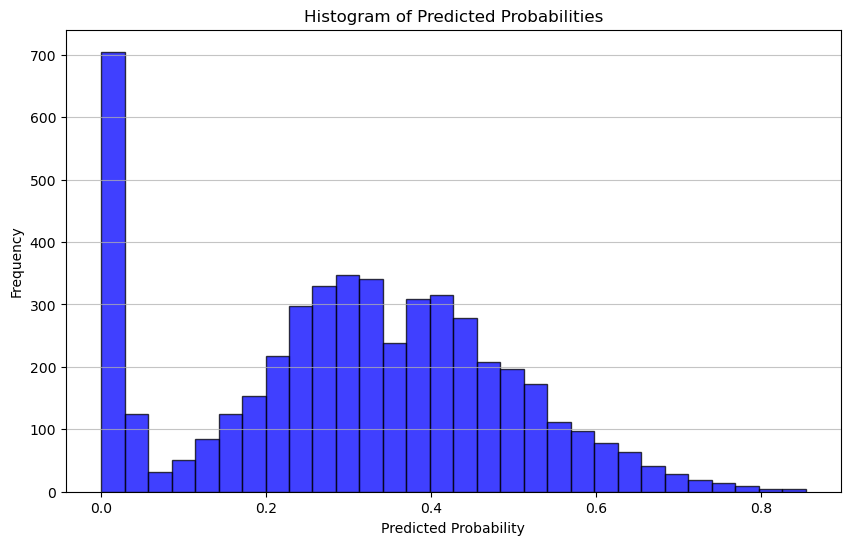

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Sharp separation between low and high probabilities typically indicates good class distinction.

Accuracy Score: 0.6874124474684811
Classification Report:
               precision    recall  f1-score   support

           0       0.69      1.00      0.81      3424
           1       0.70      0.01      0.02      1573

    accuracy                           0.69      4997
   macro avg       0.70      0.50      0.42      4997
weighted avg       0.69      0.69      0.57      4997



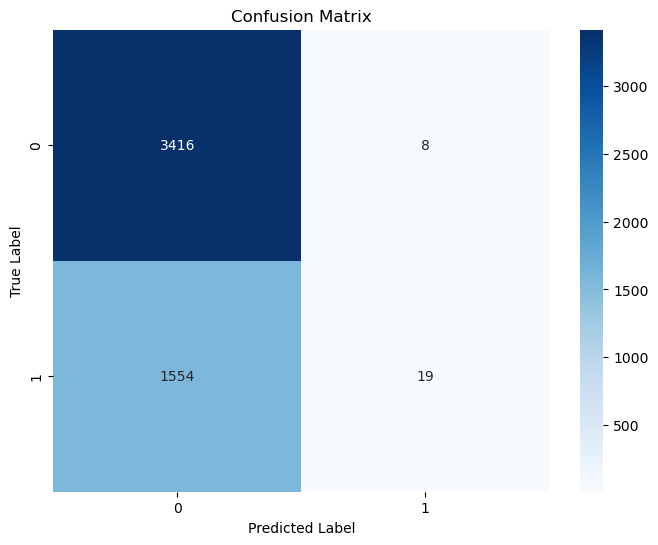

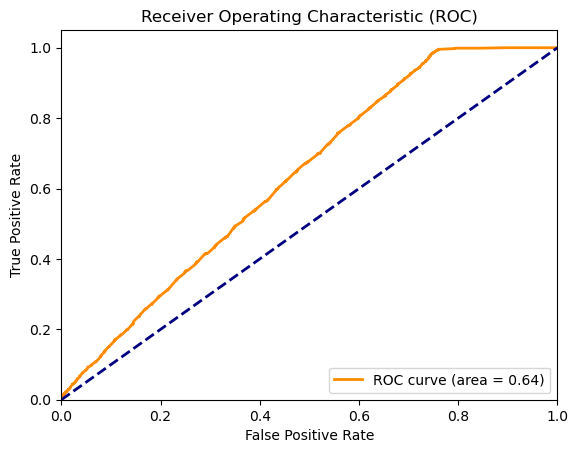

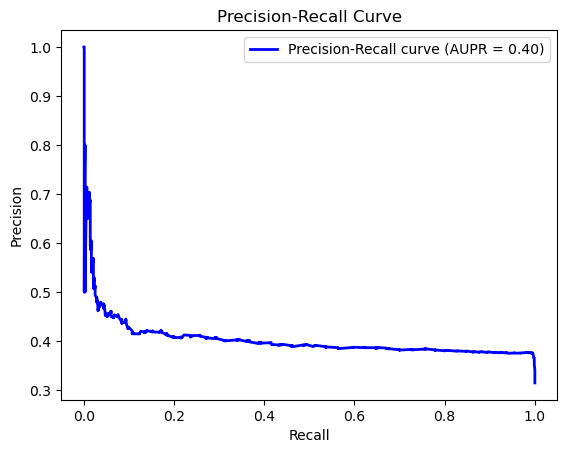

In [25]:
# Evaluating the classifier
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve and AUPR
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
aupr = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUPR = %0.2f)' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


### XGBoost Classifier with Feature Importance

This section implements an **XGBoost Classifier** to evaluate predictive power on the PCA-transformed feature set.

- Uses `'logloss'` as the evaluation metric, suitable for binary classification.
- Predicts class probabilities on the test set and applies a threshold (set to `0.8` here) for binary classification.
- The `predict_proba` output allows finer control over decision boundaries by tuning the threshold.

It also visualizes **feature importance** (based on split frequency or "weight"), helping identify the most influential features driving the model's decisions.


In [26]:
import xgboost as xgb

clf = xgb.XGBClassifier(eval_metric='logloss', random_state=30)
clf.fit(X_train_pca_df, y_train)
# Predicting the test set results
#y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test_pca_df)[:, 1]  # Get probabilities for the positive class

threshold = 0.8  # Need to Customize this value
y_pred = (y_pred_proba >= threshold).astype(int)

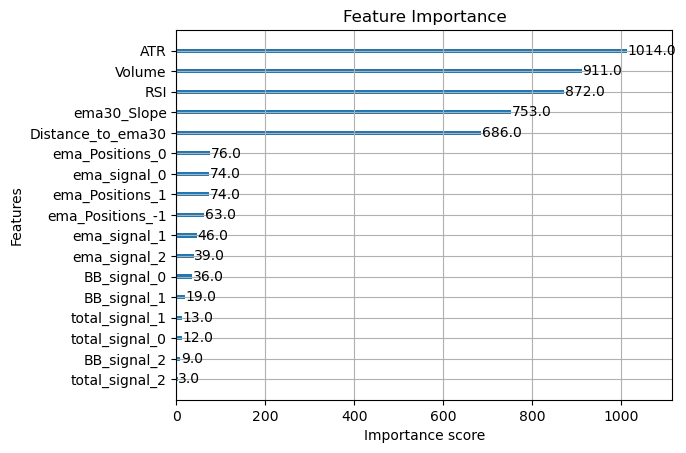

In [27]:
# Plot feature importance
xgb.plot_importance(clf, importance_type='weight')
plt.title('Feature Importance')
plt.show()

Accuracy Score: 0.6852111266760056
Classification Report:
               precision    recall  f1-score   support

           0       0.69      1.00      0.81      3424
           1       0.50      0.01      0.01      1573

    accuracy                           0.69      4997
   macro avg       0.59      0.50      0.41      4997
weighted avg       0.63      0.69      0.56      4997



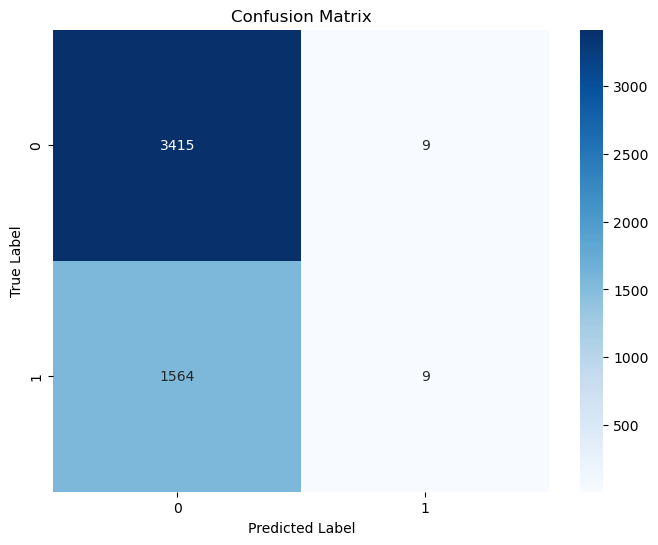

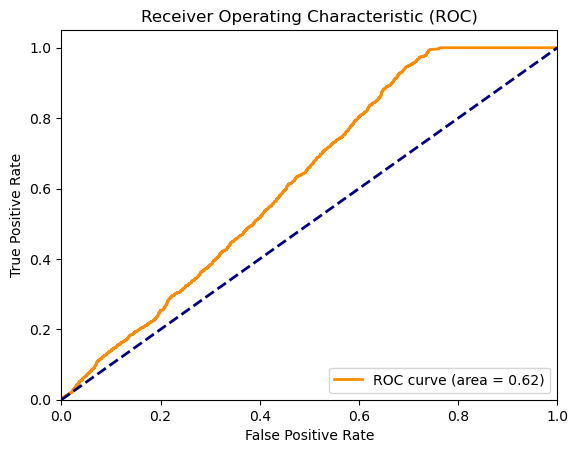

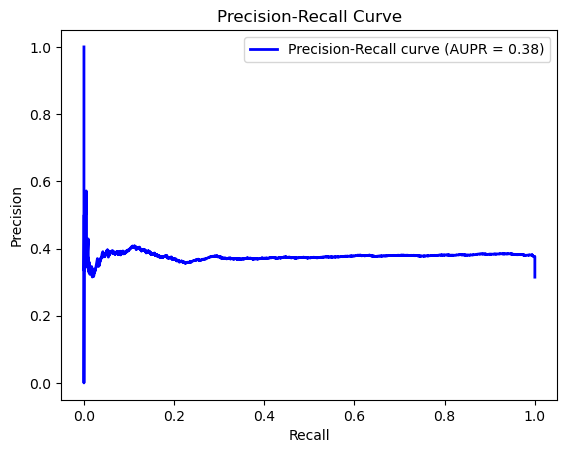

In [28]:
# Evaluating the classifier
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve and AUPR
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
aupr = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUPR = %0.2f)' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


### Neural Network Classifier (MLP)

This section implements a **Multi-Layer Perceptron (MLP) Classifier** from scikit-learn:

- The architecture includes five hidden layers with sizes `(100, 100, 100, 100, 50)`, using the ReLU activation function.
- The classifier predicts probabilities for the positive class using `predict_proba`, which allows flexible thresholding.
- A relatively low threshold (e.g., 0.3) is applied to convert probabilities into binary predictions, which may be suitable for imbalance-aware scenarios.

This flexible neural network model can capture complex nonlinear patterns in the feature space.


In [29]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100, 50), activation='relu', solver='adam', max_iter=5000, random_state=42)
clf.fit(X_train_pca_df, y_train)
y_pred_proba = clf.predict_proba(X_test_pca_df)[:, 1]

In [30]:
threshold = 0.3 # NEed to Customize this value
y_pred = (y_pred_proba >= threshold).astype(int)

Accuracy Score: 0.6037622573544127
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70      3424
           1       0.39      0.44      0.41      1573

    accuracy                           0.60      4997
   macro avg       0.56      0.56      0.56      4997
weighted avg       0.62      0.60      0.61      4997



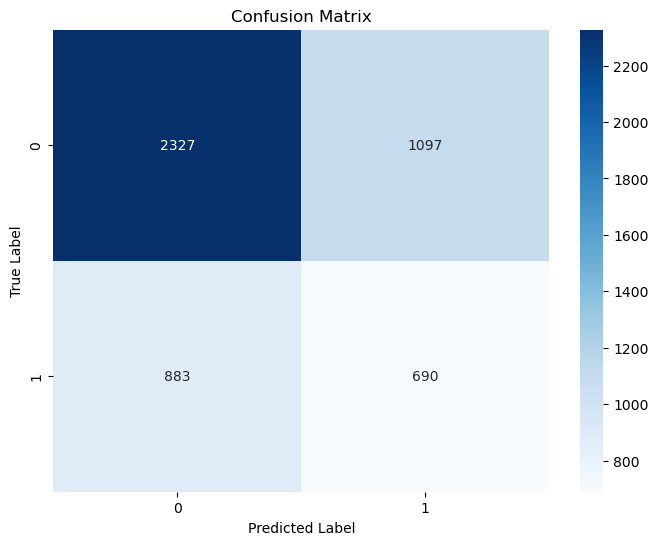

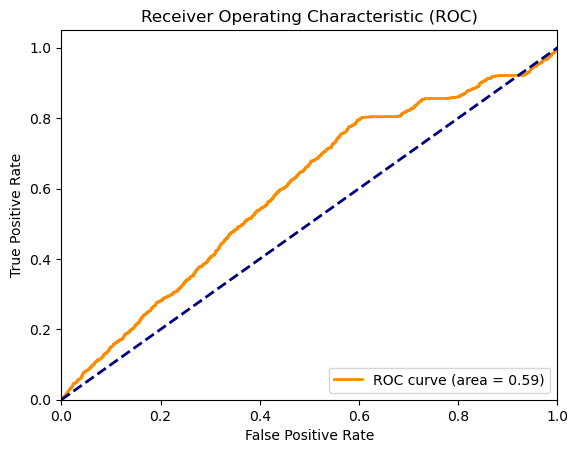

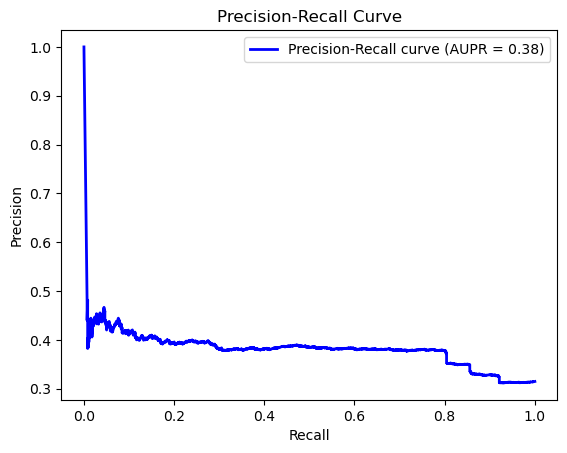

In [31]:
# Evaluating the classifier
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve and AUPR
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
aupr = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUPR = %0.2f)' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


<div style="text-align: center; border: 2px solid black; padding: 10px; background-color: green; color: white;">
    <h3><i>🏁You have reached the end of this notebook. Thank you!</i></h3>
</div>
